In [1]:
from pathlib import Path
import numpy as np
from scipy import stats
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
from moonpies import moonpies as mp
from moonpies import default_config

mpl.rcParams.update({
    'font.size': 12,
    'axes.grid': False,
    'xtick.top': False,
    'xtick.bottom': False,
})

# Set Fig paths
FIGDIR = ''  # Set or leave blank to use default (moonpies/figs)
if not FIGDIR:
    FIGDIR = default_config.Cfg().figs_path
FIGDIR = str(Path(FIGDIR).resolve() / "_")[:-1]  # add trailing slash

agg_layers = '/home/ctaiudovicic/projects/moonpies/data/out/220602/layers.csv'
#  '/home/ctaiudovicic/projects/moonpies/data/out/220408_layers.csv'
agg_runs = '/home/ctaiudovicic/projects/moonpies/data/out/220602/runs.csv'
# '/home/ctaiudovicic/projects/moonpies/data/out/220408_runs.csv'

def flatten_agg_df(df):
    """Flatten aggregated dataframe into a single indexed dataframe."""
    dflat = df.stack(level=[0, 1]).reset_index(level=0, drop=True).reset_index().rename(columns={'level_0': 'coldtrap', 'level_1': 'bsed'})
    dflat['bsed'] = dflat['bsed'] == 'Ballistic Sedimentation'
    dflat['bsed'] = dflat['bsed'].replace({True: 'Yes', False: 'No'})
    return dflat

layers = pd.read_csv(agg_layers, header=[0, 1, 2])
runs = pd.read_csv(agg_runs, header=[0, 1, 2])

# Order coldtraps by geologic era and latitude
coldtrap_order = ['Faustini','Haworth','Shoemaker','Cabeus B',"Idel'son L",'Amundsen','Cabeus','de Gerlache','Slater','Sverdrup','Wiechert J','Shackleton']
clist = mp.read_crater_list().set_index('cname').loc[coldtrap_order]
# clist = clist.sort_values('age', ascending=False)
# clist = clist.sort_values('lat', ascending=False)
sort_coldtrap = clist.index.values
sort_age = clist.age.values
sort_lat = clist.lat.values
# labels = [c+f'\n{age/1e9:.2f} Ga' for c, age in zip(sort_coldtrap, sort_age)]
labels = [c+f'\n{lat:.1f}°' for c, lat in zip(sort_coldtrap, sort_lat)]
# labels = [c+f'\ndist={90+lat:.2f}°' for c, lat in zip(sort_coldtrap, sort_lat)]

In [115]:
layers_flat = flatten_agg_df(layers)
layers_flat.loc[layers_flat['ice'] < 0.1, 'ice'] = np.nan
layers_flat.loc[layers_flat['depth'] < 0.1, 'depth'] = np.nan
layers_flat.dropna(inplace=True)

 # TODO: figure out why kde plot breaks when using clip instead
# layers_flat['ice'] = layers_flat['ice'].clip(lower=0.1) 
# layers_flat['depth'] = layers_flat['depth'].clip(lower=0.1)
layers_flat['depth_top'] = layers_flat['depth'] - layers_flat['ice']
layers_flat['depth_top'] = layers_flat['depth_top'].clip(lower=0.1)
# layers_flat.head()

<AxesSubplot:xlabel='ice', ylabel='depth_top'>

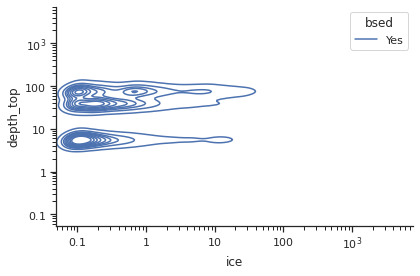

In [122]:
dg = layers_flat[(layers_flat.bsed=='Yes') & (layers_flat.coldtrap == 'de Gerlache')]
sns.kdeplot(x='ice', y='depth_top', hue='bsed', log_scale=True, data=dg)

<AxesSubplot:xlabel='ice', ylabel='depth_top'>

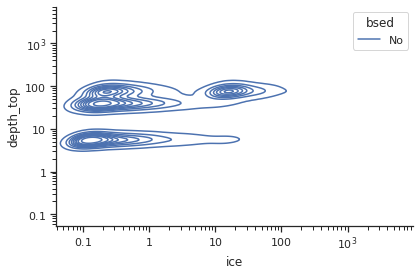

In [127]:
dg = layers_flat[(layers_flat.bsed=='No') & (layers_flat.coldtrap == 'de Gerlache')]
sns.kdeplot(x='ice', y='depth_top', hue='bsed', log_scale=True, data=dg)

1.1580918e-06


<AxesSubplot:ylabel='Frequency'>

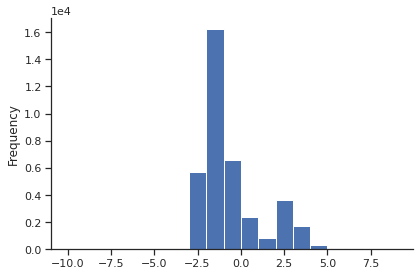

In [113]:
dg = layers_flat[(layers_flat.bsed=='Yes') & (layers_flat.coldtrap == 'de Gerlache')]
dg2 = layers_flat[(layers_flat.bsed=='No') & (layers_flat.coldtrap == 'de Gerlache')]

print(dg.ice.min())
f = plt.figure()
np.log(dg2.ice.clip(0.1)).plot.hist(bins=np.arange(-10, 10))


<AxesSubplot:ylabel='Frequency'>

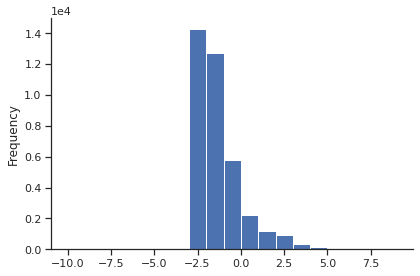

In [112]:
np.log(dg.ice.clip(0.1)).plot.hist(bins=np.arange(-10, 10))


In [29]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())
        
# sns.set(style="darkgrid")

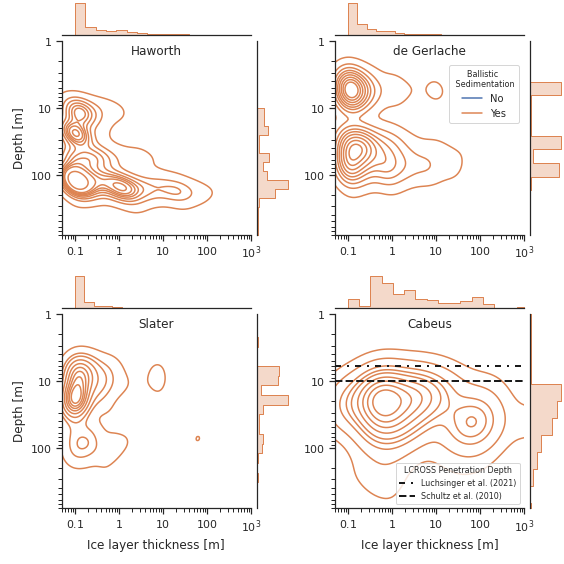

In [124]:
outpath = default_config.Cfg().figs_path + '/kde_contour_grid.pdf'
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

coldtraps = ["Haworth", "de Gerlache", "Slater", "Cabeus"]
pal = sns.color_palette()
mypal = [pal[0], pal[1]]
hues = ['No', 'Yes']
xlim = (0.05, 1000)
ylim = (1, 800)

jgs = []
for i, coldtrap in enumerate(coldtraps):
    df = layers_flat[(layers_flat.coldtrap==coldtrap)].iloc[::100]
    jg = sns.JointGrid(space=0)
    jg.ax_joint.annotate(f'{coldtrap}', xy=(0.5, 0.98), ha='center', va='top', xycoords='axes fraction')
    g = sns.kdeplot(x='ice', y='depth_top', hue='bsed', hue_order=hues, data=df, log_scale=True, 
                palette=mypal, bw_adjust=1.5, thresh=0, levels=7, common_norm=False, ax=jg.ax_joint)
    sns.histplot(x='ice', hue='bsed',  bins=20, common_norm=True,
                 hue_order=hues[::-1], palette=mypal[::-1], alpha=0.3,
                 element='step', data=df, legend=False, ax=jg.ax_marg_x)
    sns.histplot(y='depth', hue='bsed',  bins=20, common_norm=True,
                 hue_order=hues[::-1], palette=mypal[::-1], alpha=0.3,
                 element='step', data=df, legend=False, ax=jg.ax_marg_y)
    
    # Legend only in 1st subplot
    handles = jg.ax_joint.legend_.get_lines()
    jg.ax_joint.legend_.remove()
    if i == 1:
        # legend_labels = jg.ax_joint.legend_.get_texts()
        title = 'Ballistic \n Sedimentation'
        leg = jg.ax_joint.legend(handles, ['No', 'Yes'], loc="upper right", 
                                 title=title, fontsize=10, title_fontsize=8, bbox_to_anchor=(1, 0.9))
        leg.get_title().set_multialignment('center')

    # Cabeus LCROSS depths and legend
    if coldtrap == 'Cabeus':
        jg.ax_joint.axhline(6, ls=(0, (3, 3, 1, 3)), lw=2, color='k', zorder=10, label='Luchsinger et al. (2021)')
        jg.ax_joint.axhline(10, ls='--', color='k', lw=2, zorder=10, label='Schultz et al. (2010)')
        jg.ax_joint.legend(loc='lower right', title=r'LCROSS Penetration Depth', fontsize=8, title_fontsize=8)
    jgs.append(jg)

# Move all the jointgrids into a single gridspec figure
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)

for i, (jg, gs) in enumerate(zip(jgs, gs)):
    xlabel = 'Ice layer thickness [m]' if i in (2, 3) else None
    ylabel = 'Depth [m]' if i in (0, 2) else None
    jg.ax_joint.set_xlabel(xlabel)
    jg.ax_joint.set_ylabel(ylabel)
    jg.ax_joint.set_xscale('log')
    jg.ax_joint.set_yscale('log')
    jg.ax_joint.set_xlim(xlim)
    jg.ax_joint.set_ylim(ylim)
    jg.ax_joint.invert_yaxis()
    jg.ax_marg_x.yaxis.get_major_formatter().set_scientific(False)
    jg.ax_marg_y.xaxis.get_major_formatter().set_scientific(False)
    jg.ax_marg_x.xaxis.set_visible(False)
    jg.ax_marg_y.yaxis.set_visible(False)
    SeabornFig2Grid(jg, fig, gs)

# plt.savefig(outpath)
plt.show()

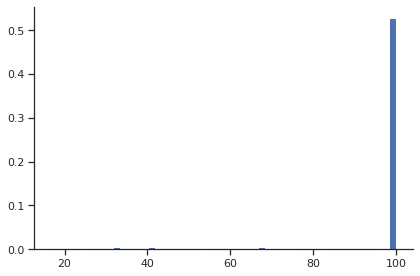

In [83]:
coldtrap = 'Cabeus'
bsed = 'Yes'
layers_flat['depth_top'] = layers_flat['depth'] - layers_flat['ice']
subdf = layers_flat[(layers_flat.bsed==bsed) & (layers_flat.coldtrap==coldtrap)]
df6 = subdf[subdf.depth < 6]
# df6 = df[(df.depth > 6)&(df.depth < 100)]
pct = 100*df6.ice / (df6.depth)
_ = plt.hist(pct[pct>0], bins=50, density=True)
# plt.xlim(2, 20)

In [2]:
seeds = np.arange(51, 151)
_CFG = default_config.Cfg(seed=0)
time_arr = mp.get_time_array(_CFG)
coldtraps = np.array(_CFG.coldtrap_names)
ast_tot = np.zeros((len(time_arr), len(seeds)), _CFG.dtype)
com_tot = np.zeros((len(time_arr), len(seeds)), _CFG.dtype)
ej = np.zeros((len(time_arr), len(coldtraps), len(seeds)), _CFG.dtype)
bsed_d = np.zeros((len(time_arr), len(coldtraps), len(seeds)), _CFG.dtype)
bsed_f = np.zeros((len(time_arr), len(coldtraps), len(seeds)), _CFG.dtype)
ages = np.zeros((len(coldtraps), len(seeds)), _CFG.dtype)

for i, seed in enumerate(seeds):
    mp.clear_cache()
    cfg = default_config.Cfg(seed=seed)
    rng = mp.get_rng(cfg)

    # Get asteroid / comet ice thicknesses
    ast = mp.get_impact_ice(time_arr, cfg, rng)
    com = mp.get_impact_ice_comet(time_arr, cfg, rng)
    ast_tot[:, i] = ast
    com_tot[:, i] = com

    # Get ejecta thicknesses
    df = mp.get_crater_list(cfg.ejecta_basins, cfg, rng)
    ej_thick, ej_sources = mp.get_ejecta_thickness_time(time_arr, df, cfg)
    # ej[:, i] = np.squeeze(ej_thick[:, np.where(np.array(cfg.coldtrap_names) == coldtrap)])
    ej[:, :, i] = ej_thick

    # Get bsed depths, fracs
    bsed_d[:, :, i], bsed_f[:, :, i] = mp.bsed_depth_petro_pieters(time_arr, df, cfg)
    ages[:, i] = df.set_index('cname').loc[coldtraps].age.values

overturn = mp.overturn_depth_time(time_arr, _CFG)
volc_tot = mp.get_volcanic_ice(time_arr, _CFG)
sw_tot = mp.get_solar_wind_ice(time_arr, _CFG)

# Make same shape as com, ast
volc_tot = np.repeat(volc_tot[:,None], len(seeds), axis=1)
sw_tot = np.repeat(sw_tot[:,None], len(seeds), axis=1)

In [3]:
def inds_before_age(time_arr, ages, coldtrap_ind):
    """
    Return all indices of a time_arr x N array before coldtrap ages
    """
    age = ages[coldtrap_ind]
    tsorted = np.argsort(time_arr)
    age_pos = np.searchsorted(time_arr[tsorted], age)
    indices = tsorted[age_pos]
    i_before_age = np.arange(len(time_arr))[:,None] < indices  # (425, nseed)
    return i_before_age


Text(0.5, 0, 'Age [Gyr]')

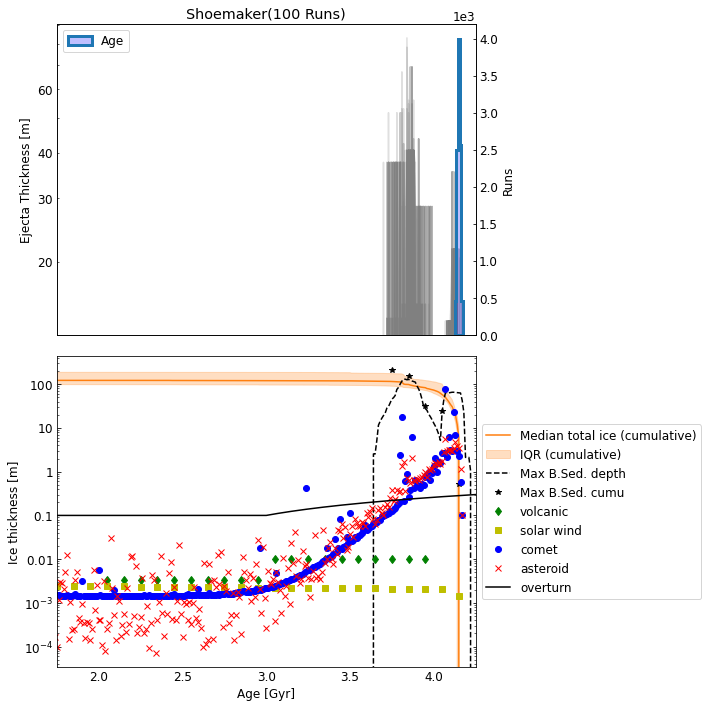

In [6]:
coldtrap = "Shoemaker"
ej_ind = np.where(coldtraps == coldtrap)[0][0]
bhops = np.array([mp.get_ballistic_hop_efficiency(c, _CFG) for c in coldtraps])
bhop = bhops[ej_ind]

# Zero out any values recorded before age of coldtrap for given seed
iba = inds_before_age(time_arr, ages, ej_ind)
ast = ast_tot.copy()
com = com_tot.copy()
volc = volc_tot.copy()
sw = sw_tot.copy()
ej_coldtrap = ej[:, ej_ind, :]
bsed_d_ct = bsed_d[:, ej_ind, :]
bsed_f_ct = bsed_f[:, ej_ind, :]
ast[iba] = 0
com[iba] = 0
volc[iba] = 0
sw[iba] = 0
ej_coldtrap[iba] = 0
bsed_d_ct[iba] = 0
bsed_f_ct[iba] = 0

# Get random crater ages
samples = 10000
rng = mp.get_rng(_CFG)
dfa = mp.read_crater_list(_CFG)
sig = dfa[['age_low', 'age_upp']].mean(axis=1)/2
a = -dfa.age_low/sig
b = dfa.age_upp/sig
rng = mp.get_rng(cfg)
S = stats.truncnorm.rvs(a, b, dfa.age, sig, (samples, len(dfa)), random_state=rng)
S = mp.round_to_ts(S, cfg.timestep) / 1e9

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 10))
ax1b = ax1.twinx()
ax1.set_title(coldtrap + f'({len(seeds)} Runs)')
time_ga = time_arr / 1e9

# Get hist of crater ages
row = dfa.loc[dfa.cname==coldtrap]
ind = row.index[0]
row = dfa.iloc[ind]
bins = np.arange(row.age-row.age_low-5e6, row.age+row.age_upp+5e6+1, 10e6)/1e9

ax1.semilogy(time_ga, ej_coldtrap, c='gray', alpha=0.25)
ax1.set_xlim(1.75, 4.25)
ax1.set_ylabel('Ejecta Thickness [m]')

ax1b.hist(S[:,ind], bins=bins, histtype='stepfilled', lw=3, label='Age', ec='tab:blue', fc=(0,0,1,0.25))
ax1b.set_ylabel('Runs')
ax1b.legend()

# plt.plot(time_arr, 100*(ast/(ast+com_tt)), 'bo', label='d')
total = ast + com + volc + sw
tot_cumu = np.cumsum(total, axis=0)
q1_cumu = np.percentile(tot_cumu, 25, axis=1)
med_cumu = np.median(tot_cumu, axis=1)
q3_cumu = np.percentile(tot_cumu, 75, axis=1)

ax2.semilogy(time_ga, med_cumu, '-', c='tab:orange', label='Median total ice (cumulative)')
ax2.fill_between(time_ga, q1_cumu, q3_cumu, alpha=0.25, color='tab:orange', label='IQR (cumulative)')

# Get max bsed depth for each time (moving window avg to smooth over missed timesteps)
window = 12
bsed_max = bsed_d_ct*bsed_f_ct
bsed_avg = np.convolve(bsed_max.max(axis=1), np.ones(window), "same")/window
ax2.semilogy(time_ga, bsed_avg, 'k--', label='Max B.Sed. depth')

# Get bsed cumu, zero our after no more bsed events
bsed_cumu = np.cumsum(bsed_d_ct*bsed_f_ct, axis=0)
bsed_cumu[-np.nonzero(bsed_d_ct[::-1].mean(axis=1))[0][0]:] = 0
ax2.semilogy(time_ga[::10], bsed_cumu.mean(axis=1)[::10], 'k*', label='Max B.Sed. cumu')

ax2.semilogy(time_ga[::10], volc.mean(axis=1)[::10], 'gd', label='volcanic')
ax2.semilogy(time_ga[::10], sw.mean(axis=1)[::10], 'ys', label='solar wind')
ax2.semilogy(time_ga, com.mean(axis=1), 'bo', label='comet')
ax2.semilogy(time_ga, ast.mean(axis=1), 'rx', label='asteroid')
ax2.semilogy(time_ga, overturn, 'k', label='overturn')


ax2.legend(loc='center left', bbox_to_anchor=(1, .5))
ax2.set_ylabel('Ice thickness [m]')
ax2.set_xlabel('Age [Gyr]')

# Plot bsed depth and frac
# window = 10
# bsed_max = bsed_d_ct*bsed_f_ct
# bsed_avg = np.convolve(bsed_max.max(axis=1), np.ones(window), "same")/window
# ax3.semilogy(time_ga, bsed_avg, 'b-', label='bsed depth')
# ax3.semilogy(time_ga, (bsed_d_ct*bsed_f_ct).mean(axis=1), 'x', label='bsed depth')
# ax3.set_ylabel('Max Ballistic Sed Ice Removal [m]')
# ax3b = ax3.twinx()
# ax3b.plot(time_ga, bsed_frac, 'bo', label='bsed frac')
# ax3b.set_ylabel('Ballistic Sed Fraction')
# ax3.legend()

In [59]:
runs_flat = flatten_agg_df(runs)
runs_flat.loc[runs_flat['total ice'] < 1, 'total ice'] = np.nan
runs_flat['log ice'] = np.log10(runs_flat['total ice'])
# runs_flat.head()  

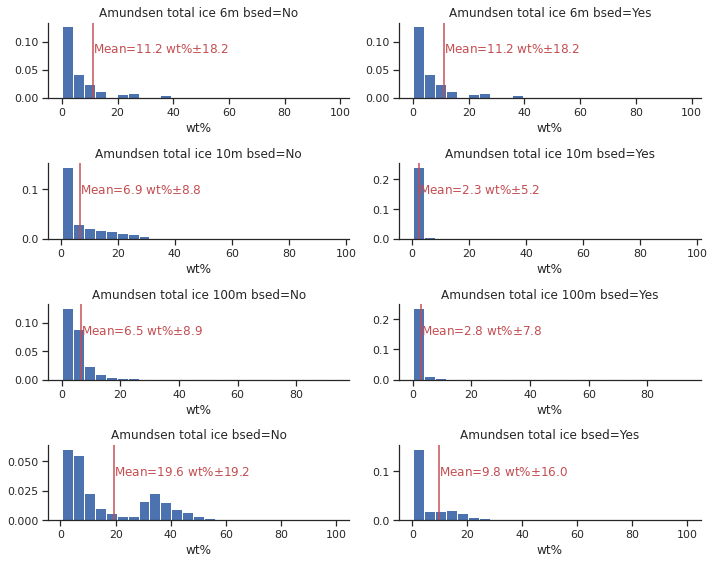

In [61]:
cfg = default_config.Cfg()
coldtrap = 'Amundsen'

fig, ax_arr = plt.subplots(4, 2, figsize=(10, 8))
for bsed, axs in zip(['No', 'Yes'], ax_arr.T):
    df = runs_flat[(runs_flat.bsed==bsed) & (runs_flat.coldtrap==coldtrap)]
    for depth,stat,ax in zip((6,10,100, None), ('total ice 6m', 'total ice 10m', 'total ice 100m', 'total ice'), axs):
        # frac = 100*df[stat] / depth
        # ax.hist(frac[frac>0], bins=25, density=True)
        # ax.set_xlabel('Ice fraction [%]')
        if depth is None:
            depth = df['max depth']
        ice_thick = df[stat]
        ice_mass = ice_thick * cfg.ice_density
        reg_thick = depth - ice_thick
        reg_mass = reg_thick * cfg.target_density
        wt_pct = 100*ice_mass / (ice_mass + reg_mass)
        wt_pct = wt_pct[wt_pct > 0]
        ax.hist(wt_pct, bins=25, density=True)
        med = wt_pct.mean()
        std = wt_pct.std()
        ax.axvline(med, c='r')
        ax.annotate(f'Mean={med:.1f} wt%$\pm${std:.1f}\n', color='r', xy=(med, 0.4), xycoords=ax.get_xaxis_transform())
        # ax.annotate(f'Mean={med:.1f}m$\pm${std:.1f}\n Frac={med/depth:.1%} $\pm${std/depth:.1%}\n cov={med/std:.3f}', color='r', xy=(med, 0.4), xycoords=ax.get_xaxis_transform())
        ax.set_title(f'{coldtrap} {stat} bsed={bsed}')
        # ax.set_xlim(0, depth)
        # ax.set_xlabel('Ice thickness [m]')
        ax.set_xlabel('wt%')

In [11]:
runs_flat.head()

,coldtrap,bsed,max depth,total ice,total ice 100m,total ice 10m,total ice 6m,log ice
0,Amundsen,Yes,1757.67270,1757.672700,0.000000,0.000000,0.0,3.244938
1,Amundsen,No,148.07544,11.014075,5.987828,0.086539,0.0,1.041948
2,Cabeus,Yes,1757.67270,1757.672700,0.000000,0.000000,0.0,3.244938
3,Cabeus,No,102.91623,65.478960,0.501340,0.000000,0.0,1.816102
4,Cabeus B,Yes,1757.67270,1757.672700,0.000000,0.000000,0.0,3.244938


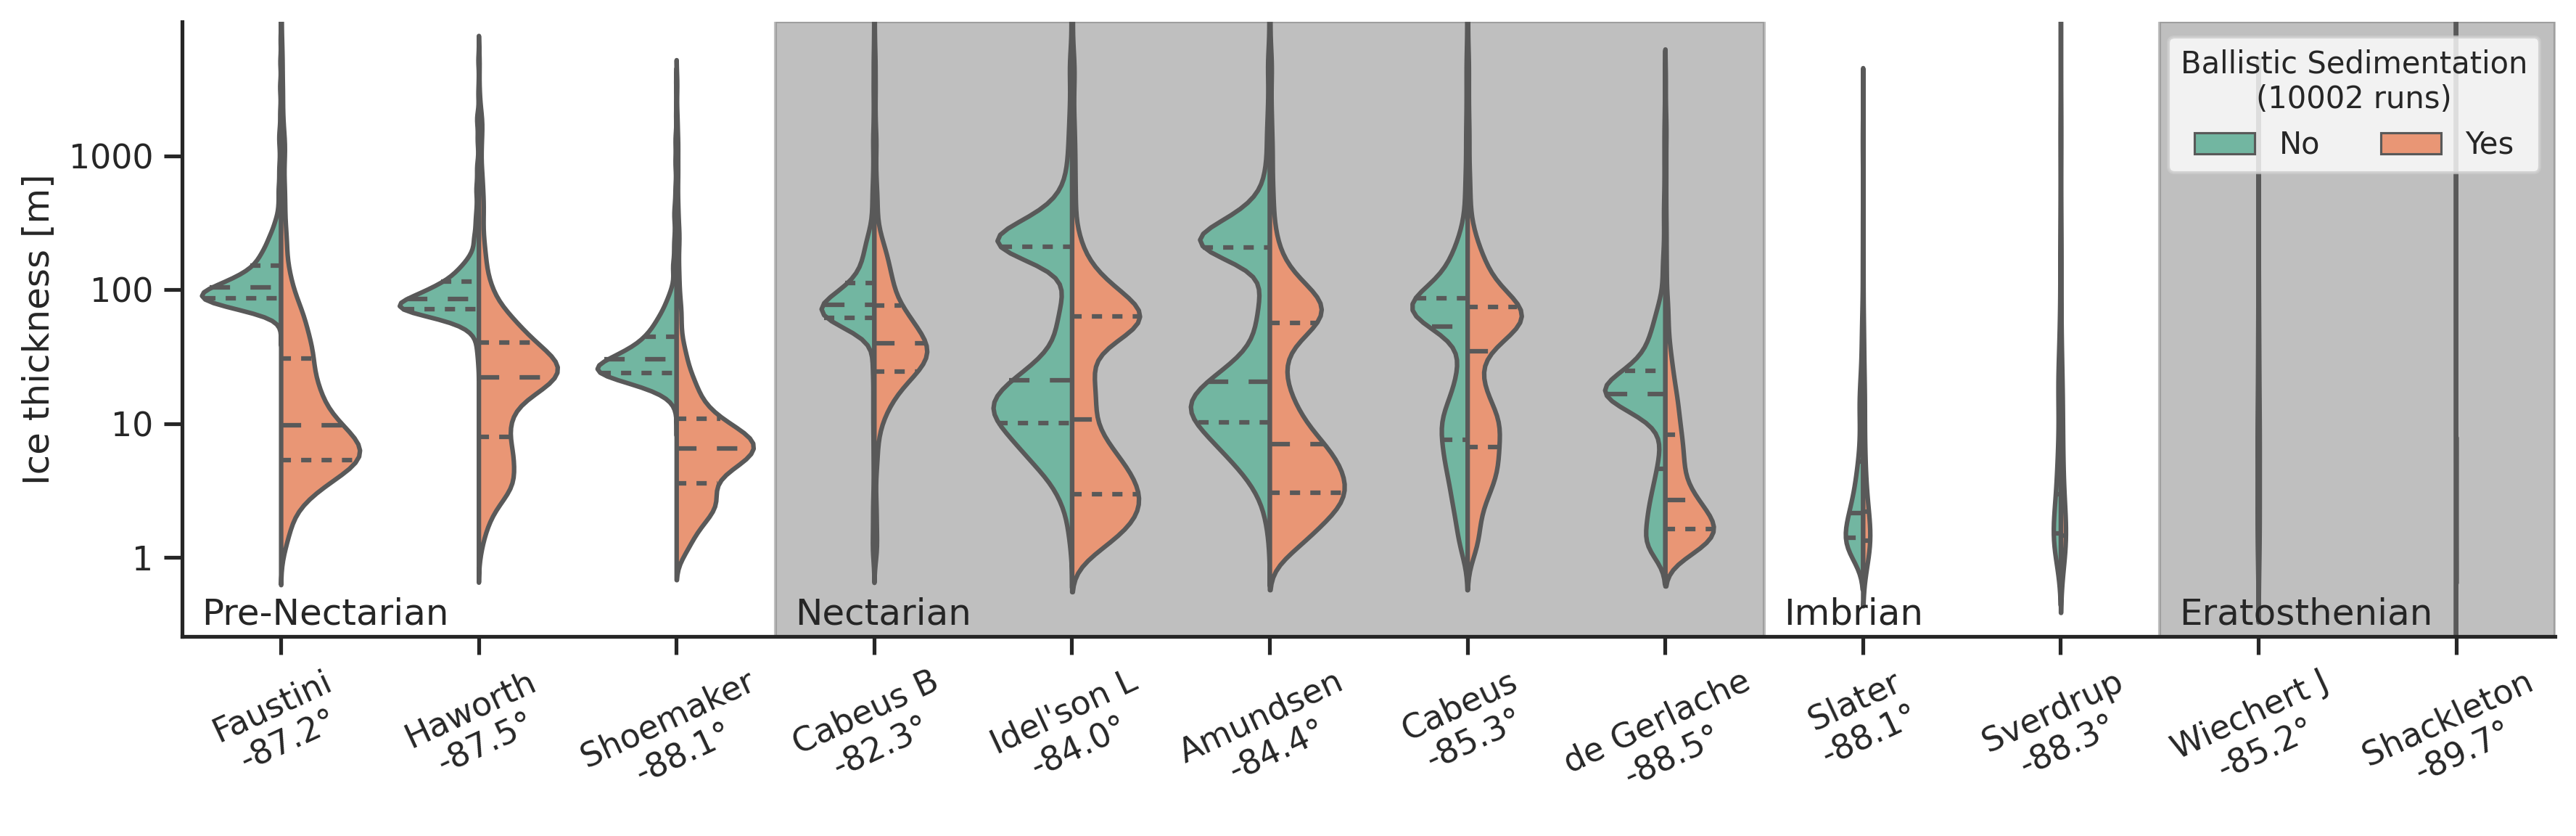

In [60]:
# Plot
fig, ax = plt.subplots(figsize=(12, 4), dpi=300)

# ax.fill_between([-0.5, 2.5], [0, 0], [3, 3], color='tab:blue', alpha=0.5)
ax.fill_between([2.5, 7.5], [-1, -1], [4, 4], color='gray', alpha=0.5)
ax.fill_between([9.5, 11.5], [-1, -1], [4, 4], color='gray', alpha=0.5)

# Test
# runs2 = runs[runs["Idel'son L", "Ballistic Sedimentation", "total ice"] > 1000]
# runs_flat = flatten_agg_df(runs2)
# runs_flat.loc[runs_flat['total ice'] < 1, 'total ice'] = np.nan
# runs_flat['log ice'] = np.log10(runs_flat['total ice'])

ax = sns.violinplot(x='coldtrap', y='log ice', hue='bsed', 
                    hue_order=['No', 'Yes'], data=runs_flat, split=True, 
                    inner='quartiles', palette='Set2', order=sort_coldtrap,
                    scale='count', scale_hue=False, ax=ax)

# Plot a specific value on the violin plot
# ax.plot(['Haworth'], [1.5], 'ro')
ax.set_xticklabels(labels, rotation=25)
ax.set_ylabel('Ice thickness [m]')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(10**ax.get_yticks())
ax.set_xlabel('')
ax.annotate('Pre-Nectarian', (-0.4, -0.5), fontsize=12)
ax.annotate('Nectarian', (2.6, -0.5), fontsize=12)
ax.annotate('Imbrian', (7.6, -0.5), fontsize=12)
ax.annotate('Eratosthenian', (9.6, -0.5), fontsize=12)
ax.set_ylim(-0.59, 4)
ax.set_xlim(-0.5, 11.5)

title = f'Ballistic Sedimentation\n({len(runs)} runs)'
leg = plt.legend(loc='upper right', ncol=2, title=title, fontsize=10, title_fontsize=10)
leg.get_title().set_multialignment('center')
# plt.savefig(FIGDIR + 'bsed_violin.png', bbox_inches='tight', facecolor='w', dpi=300)
plt.savefig(FIGDIR + 'bsed_violin.pdf', bbox_inches='tight')
plt.show()

In [58]:
runs

Slater                                            \
      Ballistic Sedimentation                                             
                    total ice total ice 6m total ice 10m total ice 100m   
0                 1757.672700          0.0      0.000000       0.000000   
1                    0.137895          0.0      0.137895       0.137895   
2                 1757.672700          0.0      0.000000       0.000000   
3                    0.096497          0.0      0.000000       0.096497   
4                    0.268260          0.0      0.000000       0.268260   
...                       ...          ...           ...            ...   
9997                      NaN          NaN           NaN            NaN   
9998                      NaN          NaN           NaN            NaN   
9999                      NaN          NaN           NaN            NaN   
10000                     NaN          NaN           NaN            NaN   
10001                     NaN          NaN           NaN            NaN   

                                                                          \
                   No Ballistic Sedimentation                              
         max depth                  total ice total ice 6m total ice 10m   
0      1757.672700                   0.596766          0.0      0.000000   
1         7.248988                   0.293607          0.0      0.171305   
2      1757.672700                   0.388263          0.0      0.000000   
3        11.218768                   1.967165          0.0      0.000000   
4        11.390533                   2.964134          0.0      0.603924   
...            ...                        ...          ...           ...   
9997           NaN                        NaN          NaN           NaN   
9998           NaN                        NaN          NaN           NaN   
9999           NaN                        NaN          NaN           NaN   
10000          NaN                        NaN          NaN           NaN   
10001          NaN                        NaN          NaN           NaN   

                                 ...                 Haworth               \
                                 ... Ballistic Sedimentation                
      total ice 100m  max depth  ...               total ice total ice 6m   
0           0.596766  78.780106  ...             1822.983300          0.0   
1           0.293607  18.526972  ...               22.595474          0.0   
2           0.388263  25.666246  ...             1822.983300          0.0   
3           1.967165  87.195120  ...               29.541294          0.0   
4           2.964134  21.197498  ...               10.174680          0.0   
...              ...        ...  ...                     ...          ...   
9997             NaN        NaN  ...               32.262440          0.0   
9998             NaN        NaN  ...                2.255246          0.0   
9999             NaN        NaN  ...               15.888221          0.0   
10000            NaN        NaN  ...                6.611606          0.0   
10001            NaN        NaN  ...               38.782814          0.0   

                                                                           \
                                               No Ballistic Sedimentation   
      total ice 10m total ice 100m   max depth                  total ice   
0               0.0       0.000000  1824.18330                  79.333910   
1               0.0       1.428787   191.66948                  71.993270   
2               0.0       0.000000  1824.18330                  56.487213   
3               0.0       0.501177   198.61531                 372.879200   
4               0.0       1.566275   179.24869                  91.096740   
...             ...            ...         ...                        ...   
9997            0.0       0.723930   201.33647                  75.141080   
9998            0.0       0.452175   171.32925            

In [54]:
runs[runs["Idel'son L", "Ballistic Sedimentation", "total ice"] > 1000]

Slater                                            \
     Ballistic Sedimentation                                             
                   total ice total ice 6m total ice 10m total ice 100m   
0                1757.672700          0.0           0.0       0.000000   
2                1757.672700          0.0           0.0       0.000000   
62                  0.201183          0.0           0.0       0.201183   
125                 0.163162          0.0           0.0       0.163162   
143                 0.352940          0.0           0.0       0.320553   
...                      ...          ...           ...            ...   
9671                     NaN          NaN           NaN            NaN   
9755                     NaN          NaN           NaN            NaN   
9837                     NaN          NaN           NaN            NaN   
9873                     NaN          NaN           NaN            NaN   
9874                     NaN          NaN           NaN            NaN   

                                                                         \
                  No Ballistic Sedimentation                              
        max depth                  total ice total ice 6m total ice 10m   
0     1757.672700                   0.596766          0.0      0.000000   
2     1757.672700                   0.388263          0.0      0.000000   
62      11.323455                   0.093650          0.0      0.000000   
125     18.396526                   0.755211          0.0      0.118797   
143    116.415610                   1.708629          0.0      0.000000   
...           ...                        ...          ...           ...   
9671          NaN                        NaN          NaN           NaN   
9755          NaN                        NaN          NaN           NaN   
9837          NaN                        NaN          NaN           NaN   
9873          NaN                        NaN          NaN           NaN   
9874          NaN                        NaN          NaN           NaN   

                                ...                 Haworth               \
                                ... Ballistic Sedimentation                
     total ice 100m  max depth  ...               total ice total ice 6m   
0          0.596766  78.780106  ...              1822.98330          0.0   
2          0.388263  25.666246  ...              1822.98330          0.0   
62         0.093650  11.215922  ...              1162.17590          0.0   
125        0.755211  78.938545  ...               447.08008          0.0   
143        1.708629  12.830900  ...              1908.14860          0.0   
...             ...        ...  ...                     ...          ...   
9671            NaN        NaN  ...               696.69946          0.0   
9755            NaN        NaN  ...              1086.33730          0.0   
9837            NaN        NaN  ...               362.29670          0.0   
9873            NaN        NaN  ...               593.82935          0.0   
9874            NaN        NaN  ...               554.61084          0.0   

                                                                          \
                                              No Ballistic Sedimentation   
     total ice 10m total ice 100m   max depth                  total ice   
0              0.0       0.000000  1824.18330                  79.333910   
2              0.0       0.000000  1824.18330                  56.487213   
62             0.0       0.466358  1331.24990                  73.801930   
125            0.0       1.330472   616.15410                 183.338490   
143            0.0       0.130552  2077.22270                 115.499214   
...            ...            ...         ...                        ...   
9671           0.0       0.525526   865.77344                  81.257225   
9755           0.0       0.665251  1255.41110                  64.983150   
9837           0.0       0.136860

In [49]:
runs_flat[(runs_flat.coldtrap=="Idel'son L") & (runs_flat['total ice'] > 1000)]

Int64Index([    10,     58,   1408,   1717,   2399,   2794,   3103,   3190,
              3763,   3872,
            ...
            164444, 165379, 165418, 165899, 166229, 166238, 166569, 166598,
            166608, 166619],
           dtype='int64', length=416)

In [43]:
ind = np.where(runs_flat[runs_flat.coldtrap=="Idel'son L"]['total ice'] > 1000)
runs_flat.iloc[ind]

,coldtrap,bsed,max depth,total ice,total ice 100m,total ice 10m,total ice 6m,log ice
0,Amundsen,Yes,1757.672700,1757.672700,0.000000,0.000000,0.000000,3.244938
4,Cabeus B,Yes,1757.672700,1757.672700,0.000000,0.000000,0.000000,3.244938
124,Cabeus B,Yes,63.740864,30.167707,30.167707,0.000000,0.000000,1.479542
153,Haworth,No,242.306720,73.232700,2.386805,0.000000,0.000000,1.864705
215,de Gerlache,No,5.629169,NaN,0.272921,0.272921,0.272921,NaN
...,...,...,...,...,...,...,...,...
19674,Slater,Yes,71.754820,NaN,0.682574,0.000000,0.000000,NaN
19741,Amundsen,No,840.370000,573.992300,17.669886,0.426466,0.000000,2.758906
19746,Faustini,Yes,231.078170,5.068204,0.317024,0.000000,0.000000,0.704854
19748,Haworth,Yes,297.763300,128.689300,0.638566,0.000000,0.000000,2.109542


In [ ]:
runs_flat[(runs_flat['total ice'] >)

In [13]:
print('Num runs (no bsed, yes bsed)')
for coldtrap in ('Slater', 'Sverdrup', 'Wiechert J', 'Shackleton'):
    no = len(runs_flat[(runs_flat.coldtrap == coldtrap) & (runs_flat['bsed'] == 'No')].dropna())
    yes = len(runs_flat[(runs_flat.coldtrap == coldtrap) & (runs_flat['bsed'] == 'Yes')].dropna())
    print(f'{coldtrap}: N={no}, Y={yes}')


Num runs (no bsed, yes bsed)
Slater: N=2191, Y=900
Sverdrup: N=901, Y=640
Wiechert J: N=135, Y=137
Shackleton: N=7, Y=9


In [14]:
runs[['Haworth', 'Faustini', 'Cabeus', 'Shackleton']].describe(percentiles=[0.5]).round(2)

Haworth                                            \
      Ballistic Sedimentation                                             
                    total ice total ice 6m total ice 10m total ice 100m   
count                10002.00     10002.00      10002.00       10002.00   
mean                    82.18         0.01          0.02           2.34   
std                    330.18         0.20          0.33           6.02   
min                      0.26         0.00          0.00           0.00   
50%                     22.00         0.00          0.00           0.88   
max                   5120.88         5.51          9.50          84.43   

                                                                       \
                No Ballistic Sedimentation                              
      max depth                  total ice total ice 6m total ice 10m   
count  10002.00                   10000.00     10000.00      10000.00   
mean     251.16                     153.97         0.01          0.02   
std      330.02                     343.09         0.20          0.33   
min      145.83                      26.08         0.00          0.00   
50%      191.06                      85.17         0.00          0.00   
max     5289.95                    5285.89         5.51          9.50   

                                ...              Shackleton               \
                                ... Ballistic Sedimentation                
      total ice 100m max depth  ...               total ice total ice 6m   
count       10000.00  10000.00  ...                   18.00        18.00   
mean            4.41    322.99  ...                  196.40         1.10   
std             7.22    343.10  ...                  568.00         1.32   
min             0.00    175.52  ...                    0.00         0.00   
50%             2.19    254.24  ...                    0.94         0.42   
max            78.72   5454.96  ...                 1757.67         4.35   

                                                                         \
                                             No Ballistic Sedimentation   
      total ice 10m total ice 100m max depth                  total ice   
count         18.00          18.00     18.00                      16.00   
mean           1.10           1.10    196.40                       1.24   
std            1.32           1.32    568.00                       1.34   
min            0.00           0.00      0.00                       0.00   
50%            0.42           0.42      0.94                       0.61   
max            4.35           4.35   1757.67                       4.35   

                                                           
                                                           
      total ice 6m total ice 10m total ice 100m max depth  
count        16.00         16.00          16.00     16.00  
mean          1.24          1.24           1.24      1.24  
std           1.34          1.34           1.34      1.34  
min           0.00          0.00           0.00      0.00  
50%           0.61          0.61           0.61      0.61  
max           4.35          4.35           4.35      4.35  

[6 rows x 40 columns]

In [15]:
runs[['Haworth', 'Faustini', 'Cabeus', 'Shackleton']].describe(percentiles=[0.5]).round(2)

Haworth                                            \
      Ballistic Sedimentation                                             
                    total ice total ice 6m total ice 10m total ice 100m   
count                10002.00     10002.00      10002.00       10002.00   
mean                    82.18         0.01          0.02           2.34   
std                    330.18         0.20          0.33           6.02   
min                      0.26         0.00          0.00           0.00   
50%                     22.00         0.00          0.00           0.88   
max                   5120.88         5.51          9.50          84.43   

                                                                       \
                No Ballistic Sedimentation                              
      max depth                  total ice total ice 6m total ice 10m   
count  10002.00                   10000.00     10000.00      10000.00   
mean     251.16                     153.97         0.01          0.02   
std      330.02                     343.09         0.20          0.33   
min      145.83                      26.08         0.00          0.00   
50%      191.06                      85.17         0.00          0.00   
max     5289.95                    5285.89         5.51          9.50   

                                ...              Shackleton               \
                                ... Ballistic Sedimentation                
      total ice 100m max depth  ...               total ice total ice 6m   
count       10000.00  10000.00  ...                   18.00        18.00   
mean            4.41    322.99  ...                  196.40         1.10   
std             7.22    343.10  ...                  568.00         1.32   
min             0.00    175.52  ...                    0.00         0.00   
50%             2.19    254.24  ...                    0.94         0.42   
max            78.72   5454.96  ...                 1757.67         4.35   

                                                                         \
                                             No Ballistic Sedimentation   
      total ice 10m total ice 100m max depth                  total ice   
count         18.00          18.00     18.00                      16.00   
mean           1.10           1.10    196.40                       1.24   
std            1.32           1.32    568.00                       1.34   
min            0.00           0.00      0.00                       0.00   
50%            0.42           0.42      0.94                       0.61   
max            4.35           4.35   1757.67                       4.35   

                                                           
                                                           
      total ice 6m total ice 10m total ice 100m max depth  
count        16.00         16.00          16.00     16.00  
mean          1.24          1.24           1.24      1.24  
std           1.34          1.34           1.34      1.34  
min           0.00          0.00           0.00      0.00  
50%           0.61          0.61           0.61      0.61  
max           4.35          4.35           4.35      4.35  

[6 rows x 40 columns]